In [1]:
import optuna
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from scipy.stats import skew
from collections import Counter
import shap
import lime
import lime.lime_tabular

# sklearn
from sklearn.model_selection import (
    cross_val_score, KFold, StratifiedKFold,
    train_test_split, RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import (
    precision_score, recall_score, confusion_matrix, roc_auc_score,
    RocCurveDisplay, accuracy_score, f1_score, classification_report,
    balanced_accuracy_score, fbeta_score, precision_recall_curve, roc_curve, PrecisionRecallDisplay)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder,
    OrdinalEncoder, PowerTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance


# imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

import warnings
warnings.filterwarnings('ignore')

<br>

### Loading data

In [2]:
# load base data
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

# load age & sex matched data
X_train_matched = pd.read_pickle('X_train_matched.pkl')
X_test_matched = pd.read_pickle('X_test_matched.pkl')
y_train_matched = pd.read_pickle('y_train_matched.pkl')
y_test_matched = pd.read_pickle('y_test_matched.pkl')


n_iterations = 100     # for hyperparmeter tuning
cv_folds = 5           # number of cross validation folds for hyperparameter tuning

The best MLP model was the smaller search space from the under&oversampled model

<br>

### Undersampling controls

In [3]:
# undersampling controls
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
X_train_smote, y_train_smote = undersampler.fit_resample(X_train, y_train)

print("before undersampling:")
print(y_train.value_counts())
print("\nafter undersampling:")
print(y_train_smote.value_counts())

before undersampling:
Heart_Disease
0    227106
1     19977
Name: count, dtype: int64

after undersampling:
Heart_Disease
0    39954
1    19977
Name: count, dtype: int64


In [ ]:
# hyperparameter tuning (smaller search space)

def objective(trial):
    # hyperparameters relevant to MLP
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [
            (64,), (128,), (256,), 
            (64, 32), (128, 64), (256, 128),
            (64, 32, 16), (128, 64, 32)
        ]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
        'solver': 'adam',
        'random_state': 1,
        'verbose': False }
    

    # create model with above parameters
    model = MLPClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, scoring='recall', n_jobs=1)
    return scores.mean()


# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

Precision: 0.2324
Recall: 0.6464
AUROC: 0.8220

Confusion Matrix 
TN FP 
FN TP:
[[46114 10663]
 [ 1766  3228]]


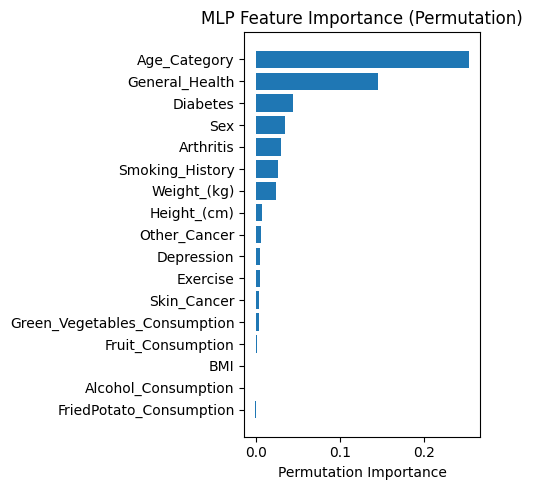

<Figure size 300x300 with 0 Axes>

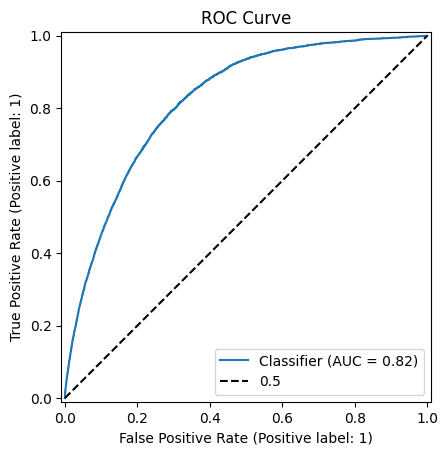

<Figure size 300x300 with 0 Axes>

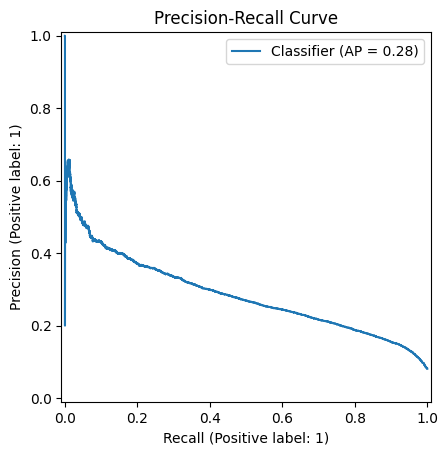

In [8]:
# model evaluation (smaller search space)
mlp_params = {
    'hidden_layer_sizes': (128, 64),
    'activation': 'tanh',
    'alpha': 0.0021334508780254734,
    'learning_rate_init': 0.012751597078588575,
    'batch_size': 256,
    'max_iter': 314,
    'n_iter_no_change': 9,
    
    # normal params:
    'solver': 'adam',
    'random_state': 2024,
    'early_stopping': True,
    'validation_fraction': 0.1,
    'verbose': False,
    'learning_rate': 'constant'}

# train the final model
mlp_model = MLPClassifier(**mlp_params)
mlp_model.fit(X_train_smote, y_train_smote)

# make predictions with test set
y_pred = mlp_model.predict(X_test)
y_pred_proba = mlp_model.predict_proba(X_test)[:, 1]

# eval metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    mlp_model, X_test, y_test, 
    n_repeats=10, 
    random_state=1,
    scoring='recall')

feature_names = X_train_smote.columns if hasattr(X_train_smote, 'columns') else [f'Feature_{i}' for i in range(X_train_smote.shape[1])]
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('MLP Feature Importance (Permutation)')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>


In [ ]:
# hyperparameter tuning (larger search space)

n_iterations = 500 # have to increase so all layer options are explored
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    hidden_layer_sizes = []
    
    for i in range(n_layers):
        layer_size = trial.suggest_int(f'layer_{i}_size', 32, 512)
        hidden_layer_sizes.append(layer_size)
    
    # hyperparameters relevant to MLP
    params = {
        'hidden_layer_sizes': tuple(hidden_layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
        'solver': 'adam',
        'beta_1': trial.suggest_float('beta_1', 0.8, 0.999),
        'beta_2': trial.suggest_float('beta_2', 0.9, 0.9999),
        'early_stopping': True,
        'validation_fraction': 0.1,
        'random_state': 1,
        'verbose': False
    }

    # create model with above parameters
    model = MLPClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, scoring='recall', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

# Extract the actual MLP parameters for final training
best_mlp_params = {k: v for k, v in study.best_params.items() 
                   if k not in ['n_layers', 'layer_0_size', 'layer_1_size', 'layer_2_size', 'layer_3_size']}

# Reconstruct hidden_layer_sizes from the layer sizes
hidden_layers = []
for i in range(study.best_params['n_layers']):
    hidden_layers.append(study.best_params[f'layer_{i}_size'])
best_mlp_params['hidden_layer_sizes'] = tuple(hidden_layers)

print("\nActual MLP parameters for training:")
for param, value in best_mlp_params.items():
    print(f"{param}: {value}")

[I 2025-10-06 04:20:01,650] A new study created in memory with name: no-name-e1a1b204-1567-4314-ae00-0ed31e10fefe


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-10-06 04:23:06,888] Trial 0 finished with value: 0.6390599746009586 and parameters: {'n_layers': 3, 'layer_0_size': 338, 'layer_1_size': 355, 'layer_2_size': 310, 'activation': 'tanh', 'alpha': 0.059249382213672847, 'learning_rate_init': 0.0027183049100367703, 'batch_size': 256, 'max_iter': 242, 'n_iter_no_change': 13, 'learning_rate': 'constant', 'beta_1': 0.9651930051379132, 'beta_2': 0.9677775146493439}. Best is trial 0 with value: 0.6390599746009586.
[I 2025-10-06 04:23:57,305] Trial 1 finished with value: 0.0 and parameters: {'n_layers': 2, 'layer_0_size': 152, 'layer_1_size': 201, 'activation': 'logistic', 'alpha': 0.06473828837673655, 'learning_rate_init': 0.027744114027677114, 'batch_size': 32, 'max_iter': 764, 'n_iter_no_change': 6, 'learning_rate': 'constant', 'beta_1': 0.8361336060704759, 'beta_2': 0.9123865135317888}. Best is trial 0 with value: 0.6390599746009586.
[I 2025-10-06 04:24:36,118] Trial 2 finished with value: 0.6196049134356788 and parameters: {'n_layers

Precision: 0.2332
Recall: 0.6804
AUROC: 0.8303

Confusion Matrix 
TN FP 
FN TP:
[[45602 11175]
 [ 1596  3398]]


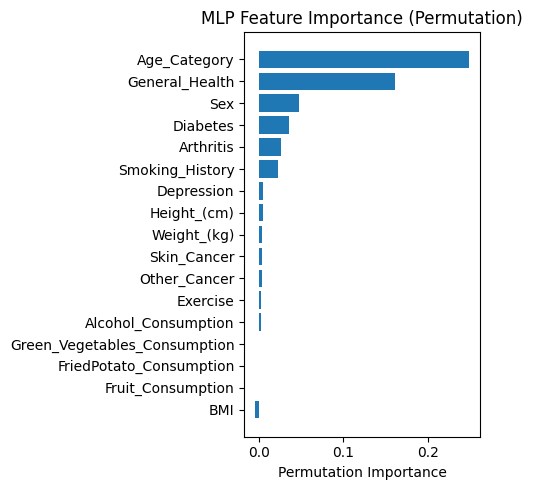

<Figure size 300x300 with 0 Axes>

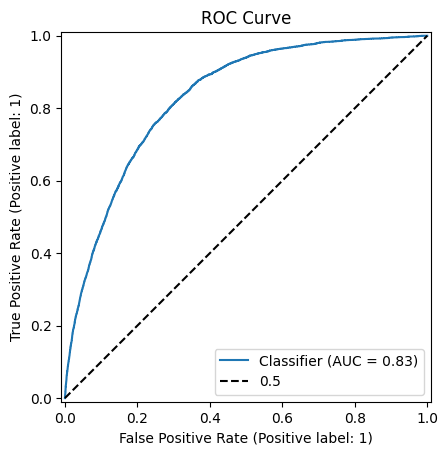

<Figure size 300x300 with 0 Axes>

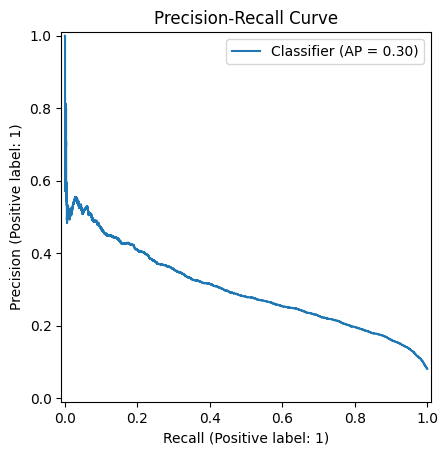

In [6]:
# model evaluation (larger search space)
mlp_params = {
    'hidden_layer_sizes': (236,),
    'activation': 'logistic',
    'alpha': 0.007726949766739205,
    'learning_rate_init': 0.02777698106500789,
    'batch_size': 256,
    'max_iter': 196,
    'n_iter_no_change': 20,
    'learning_rate': 'constant',
    'beta_1': 0.8145037909120189,
    'beta_2': 0.9925617061264882,
    
    # normal params:
    'solver': 'adam',
    'random_state': 2024,
    'early_stopping': True,
    'validation_fraction': 0.1,
    'verbose': False,
    'learning_rate': 'constant'}

# train the final model
mlp_model = MLPClassifier(**mlp_params)
mlp_model.fit(X_train_smote, y_train_smote)

# make predictions with test set
y_pred = mlp_model.predict(X_test)
y_pred_proba = mlp_model.predict_proba(X_test)[:, 1]

# eval metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    mlp_model, X_test, y_test, 
    n_repeats=10, 
    random_state=1,
    scoring='recall')

feature_names = X_train_smote.columns if hasattr(X_train_smote, 'columns') else [f'Feature_{i}' for i in range(X_train_smote.shape[1])]
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('MLP Feature Importance (Permutation)')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>

### Age & sex matched

In [3]:
def objective(trial):
    # hyperparameters relevant to MLP
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [
            (64,), (128,), (256,), 
            (64, 32), (128, 64), (256, 128),
            (64, 32, 16), (128, 64, 32)
        ]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
        'solver': 'adam',
        'random_state': 1,
        'verbose': False }
    

    # create model with above parameters
    model = MLPClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train_matched, y_train_matched, cv=cv, scoring='recall', n_jobs=1)
    return scores.mean()


# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

[I 2025-10-06 21:18:11,165] A new study created in memory with name: no-name-b4496653-99e9-4dd9-a25e-e746abc96cd7


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 21:19:29,026] Trial 0 finished with value: 0.03569755153393223 and parameters: {'hidden_layer_sizes': (128,), 'activation': 'logistic', 'alpha': 0.051258255874978766, 'learning_rate_init': 0.0005508973212793812, 'batch_size': 32, 'max_iter': 728, 'n_iter_no_change': 16}. Best is trial 0 with value: 0.03569755153393223.
[I 2025-10-06 21:20:39,357] Trial 1 finished with value: 0.043602079210405695 and parameters: {'hidden_layer_sizes': (256,), 'activation': 'relu', 'alpha': 2.962527570812667e-05, 'learning_rate_init': 0.00010593968165226812, 'batch_size': 256, 'max_iter': 437, 'n_iter_no_change': 15}. Best is trial 1 with value: 0.043602079210405695.
[I 2025-10-06 21:21:01,906] Trial 2 finished with value: 0.03523522555433532 and parameters: {'hidden_layer_sizes': (128,), 'activation': 'tanh', 'alpha': 0.0012608771962887438, 'learning_rate_init': 0.00012182785076731358, 'batch_size': 256, 'max_iter': 515, 'n_iter_no_change': 15}. Best is trial 1 with value: 0.04360207921040

Precision: 0.5336
Recall: 0.0477
AUROC: 0.8310

Confusion Matrix 
TN FP 
FN TP:
[[56569   208]
 [ 4756   238]]


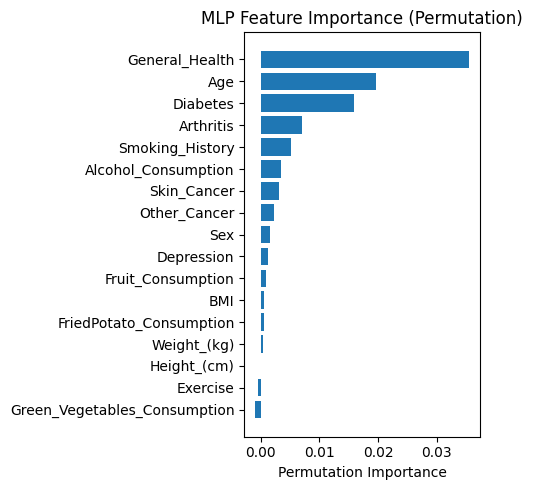

<Figure size 300x300 with 0 Axes>

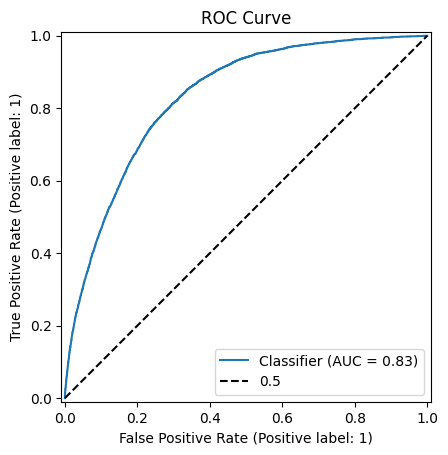

<Figure size 300x300 with 0 Axes>

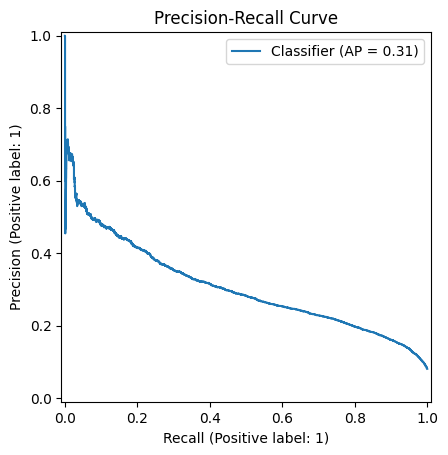

In [5]:
# model evaluation (smaller search space)
mlp_params = {
    'hidden_layer_sizes': (128,),
    'activation': 'logistic',
    'alpha': 0.04178798566873974,
    'learning_rate_init': 0.0005896570086678846,
    'batch_size': 128,
    'max_iter': 726,
    'n_iter_no_change': 17,
    
    # normal params:
    'solver': 'adam',
    'random_state': 2024,
    'early_stopping': True,
    'validation_fraction': 0.1,
    'verbose': False,
    'learning_rate': 'constant'}

# train the final model
mlp_model = MLPClassifier(**mlp_params)
mlp_model.fit(X_train_matched, y_train_matched)

# make predictions with test set
y_pred = mlp_model.predict(X_test_matched)
y_pred_proba = mlp_model.predict_proba(X_test_matched)[:, 1]

# eval metrics
precision = precision_score(y_test_matched, y_pred)
recall = recall_score(y_test_matched, y_pred)
conf_matrix = confusion_matrix(y_test_matched, y_pred)
auroc = roc_auc_score(y_test_matched, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    mlp_model, X_test_matched, y_test_matched, 
    n_repeats=10, 
    random_state=1,
    scoring='recall')

feature_names = X_train_matched.columns if hasattr(X_train_matched, 'columns') else [f'Feature_{i}' for i in range(X_train_matched.shape[1])]
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('MLP Feature Importance (Permutation)')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test_matched, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test_matched, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>

### Oversampling cases and undersampling controls to get 50-50

In [3]:
# over and undersample to get a 50/50 distribution
original_counts = Counter(y_train)
cases = min(original_counts, key=original_counts.get)
controls = max(original_counts, key=original_counts.get)
cases_count = original_counts[cases]
controls_count = original_counts[controls]

print('Before sampling:', y_train.value_counts())
target_size = cases_count * 2

# oversample cases
random_oversampler = RandomOverSampler(sampling_strategy={cases: target_size}, random_state=1)
X_oversampled, y_oversampled = random_oversampler.fit_resample(X_train, y_train)

# undersample controls
undersampler = RandomUnderSampler(sampling_strategy={controls: target_size}, random_state=1)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_oversampled, y_oversampled)

print('\nFinal distribution:', y_train_balanced.value_counts())

Before sampling: Heart_Disease
0    227106
1     19977
Name: count, dtype: int64

Final distribution: Heart_Disease
0    39954
1    39954
Name: count, dtype: int64


In [19]:
# hyperparameter tuning (smaller search space)

def objective(trial):
    # hyperparameters relevant to MLP
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [
            (64,), (128,), (256,), 
            (64, 32), (128, 64), (256, 128),
            (64, 32, 16), (128, 64, 32)
        ]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
        'solver': 'adam',
        'random_state': 1,
        'verbose': False }
    

    # create model with above parameters
    model = MLPClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='recall', n_jobs=1)
    return scores.mean()


# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

[I 2025-10-06 23:50:17,229] A new study created in memory with name: no-name-c17e9bb0-886d-4fa7-af8e-143031e1567a


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 23:50:29,775] Trial 0 finished with value: 0.8098422642816413 and parameters: {'hidden_layer_sizes': (128,), 'activation': 'logistic', 'alpha': 1.8531997313530384e-05, 'learning_rate_init': 0.016688831289174796, 'batch_size': 256, 'max_iter': 857, 'n_iter_no_change': 15}. Best is trial 0 with value: 0.8098422642816413.
[I 2025-10-06 23:51:21,136] Trial 1 finished with value: 0.8172160526954017 and parameters: {'hidden_layer_sizes': (256,), 'activation': 'logistic', 'alpha': 0.0003593926013015999, 'learning_rate_init': 0.0005428341967480254, 'batch_size': 32, 'max_iter': 851, 'n_iter_no_change': 20}. Best is trial 1 with value: 0.8172160526954017.
[I 2025-10-06 23:51:24,530] Trial 2 finished with value: 0.8129926198290871 and parameters: {'hidden_layer_sizes': (128,), 'activation': 'relu', 'alpha': 0.013743856495209778, 'learning_rate_init': 0.004235893215233463, 'batch_size': 256, 'max_iter': 943, 'n_iter_no_change': 6}. Best is trial 1 with value: 0.8172160526954017.
[I 

Precision: 0.2010
Recall: 0.7889
AUROC: 0.8297
Accuracy: 0.7294

Confusion Matrix 
TN FP 
FN TP:
[[41114 15663]
 [ 1054  3940]]


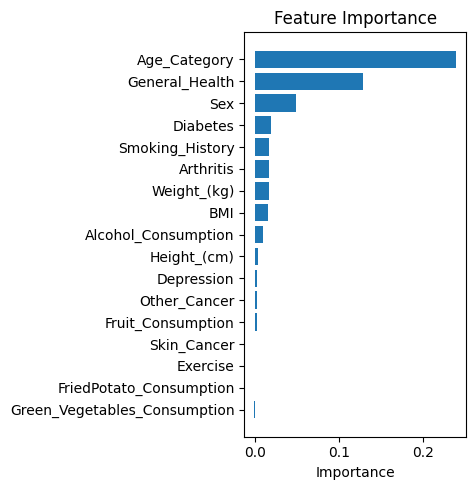

<Figure size 300x300 with 0 Axes>

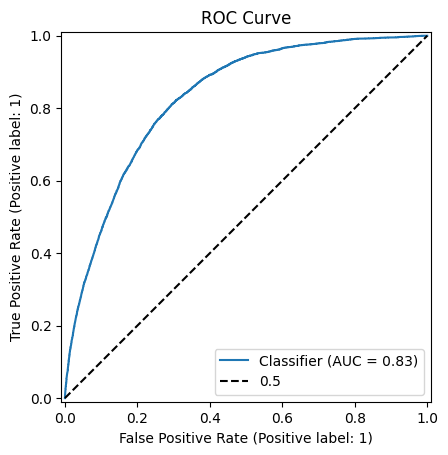

<Figure size 300x300 with 0 Axes>

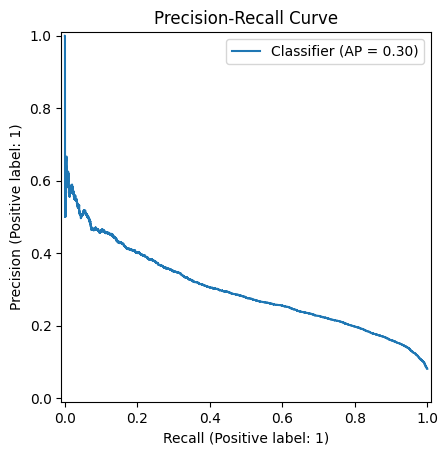

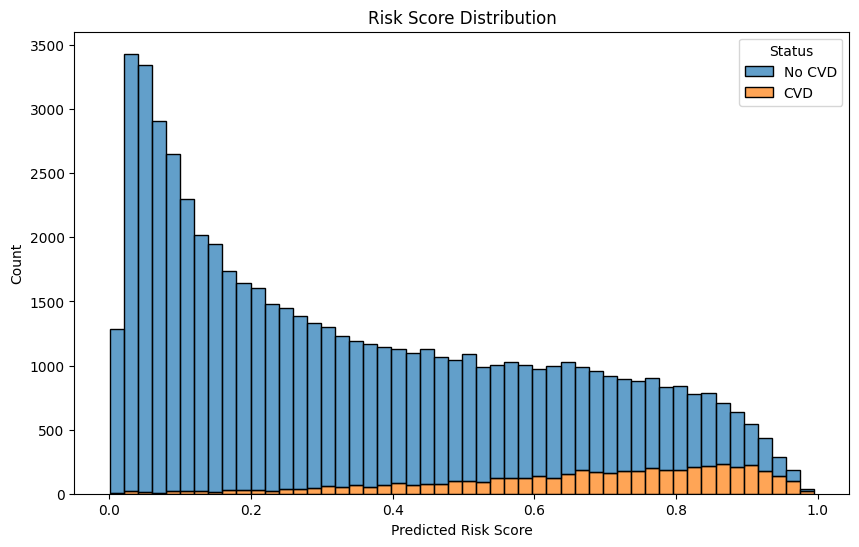

In [4]:
# model evaluation (smaller search space)
mlp_params = {
    'hidden_layer_sizes': (256,),
    'activation': 'relu',
    'alpha': 0.003978846415603185,
    'learning_rate_init': 0.00038170732447284574,
    'batch_size': 128,
    'max_iter': 248,
    'n_iter_no_change': 17,
    
    # normal params:
    'solver': 'adam',
    'random_state': 2024,
    'early_stopping': True,
    'validation_fraction': 0.1,
    'verbose': False,
    'learning_rate': 'constant'}

# train the final model
mlp_model = MLPClassifier(**mlp_params)
mlp_model.fit(X_train_balanced, y_train_balanced)

# make predictions with test set
y_pred = mlp_model.predict(X_test)
y_pred_proba = mlp_model.predict_proba(X_test)[:, 1]

# eval metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)


# Calculate permutation importance
perm_importance = permutation_importance(
    mlp_model, X_test, y_test, 
    n_repeats=100, 
    random_state=1,
    scoring='recall')

feature_names = X_train_balanced.columns if hasattr(X_train_balanced, 'columns') else [f'Feature_{i}' for i in range(X_train_balanced.shape[1])]
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


# risk score distribution
plot_data = pd.DataFrame({'risk_score': y_pred_proba, 'actual_case': y_test })
plot_data['Status'] = plot_data['actual_case'].map({0: 'No CVD', 1: 'CVD'})

# histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_data, x='risk_score', hue='Status', bins=50, alpha=0.7, multiple='stack')
plt.xlabel('Predicted Risk Score')
plt.title('Risk Score Distribution')
plt.show()

In [36]:
# feature importance (LIME)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_balanced.values,  # Use balanced training data
    feature_names=X_train_balanced.columns.tolist(),
    class_names=['No CVD', 'CVD'],
    mode='classification',
    training_labels=y_train_balanced,
    random_state=1,
    discretize_continuous=False  )

# using all 61k individuals in testing set
def get_lime_feature_importance(explainer, model, X_data, n_instances=None):
    if n_instances is None or n_instances > len(X_data):
        indices = range(len(X_data))
    else:
        indices = np.random.choice(len(X_data), n_instances, replace=False)
    
    feature_weights = []
    
    for idx in indices:
        exp = explainer.explain_instance(
            X_data.iloc[idx].values if hasattr(X_data, 'iloc') else X_data[idx],
            model.predict_proba,
            num_features=len(X_train_balanced.columns))
        
        # feature weights for class 1 (CVD)
        weights = dict(exp.as_list(label=1))
        feature_weights.append(weights)
    
    return feature_weights

# calculate LIME feature importance using ALL instances
lime_importances = get_lime_feature_importance(explainer, mlp_model, X_test, n_instances=None)

# feature importance across instances
feature_importance_lime = {}
for feature in X_train_balanced.columns:
    feature_importance_lime[feature] = np.mean([weights.get(feature, 0) for weights in lime_importances])

# sort features by absolute importance
sorted_features = sorted(feature_importance_lime.items(), 
                        key=lambda x: abs(x[1]), 
                        reverse=False)

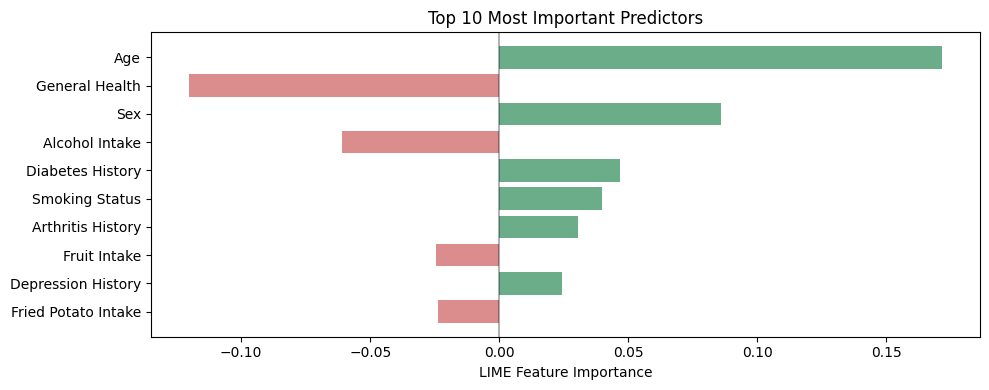

In [46]:
# name mapping & feature importance plot
name_mapping = {
    'Weight_(kg)': 'Weight',
    'Green_Vegetables_Consumption': 'Green Vegetable Intake',
    'Exercise': 'Physical Activity',
    'Skin_Cancer': 'Skin Cancer History',
    'Other_Cancer': 'Other Cancer History', 
    'BMI': 'Body Mass Index',
    'Height_(cm)': 'Height',
    'FriedPotato_Consumption': 'Fried Potato Intake',
    'Depression': 'Depression History',
    'Fruit_Consumption': 'Fruit Intake',
    'Arthritis': 'Arthritis History',
    'Smoking_History': 'Smoking Status',
    'Diabetes': 'Diabetes History',
    'Alcohol_Consumption': 'Alcohol Intake',
    'Sex': 'Sex',
    'General_Health': 'General Health',
    'Age_Category': 'Age'}

sorted_features_renamed = [(name_mapping.get(feature, feature), importance) 
                          for feature, importance in sorted_features]

# plot
plt.figure(figsize=(10, 4))
features_plot = [x[0] for x in sorted_features_renamed[7:]]
importance_plot = [x[1] for x in sorted_features_renamed[7:]]
colors = ['indianred' if x < 0 else 'seagreen' for x in importance_plot]
plt.barh(features_plot, importance_plot, color=colors, alpha=0.7)
plt.xlabel('LIME Feature Importance')
plt.title('Top 10 Most Important Predictors')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

<br>

In [6]:
# hyperparameter tuning (larger search space)

n_iterations = 500 # have to increase so all layer options are explored
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    hidden_layer_sizes = []
    
    for i in range(n_layers):
        layer_size = trial.suggest_int(f'layer_{i}_size', 32, 512)
        hidden_layer_sizes.append(layer_size)
    
    # hyperparameters relevant to MLP
    params = {
        'hidden_layer_sizes': tuple(hidden_layer_sizes),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
        'solver': 'adam',
        'beta_1': trial.suggest_float('beta_1', 0.8, 0.999),
        'beta_2': trial.suggest_float('beta_2', 0.9, 0.9999),
        'early_stopping': True,
        'validation_fraction': 0.1,
        'random_state': 1,
        'verbose': False
    }

    # create model with above parameters
    model = MLPClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='recall', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

# Extract the actual MLP parameters for final training
best_mlp_params = {k: v for k, v in study.best_params.items() 
                   if k not in ['n_layers', 'layer_0_size', 'layer_1_size', 'layer_2_size', 'layer_3_size']}

# Reconstruct hidden_layer_sizes from the layer sizes
hidden_layers = []
for i in range(study.best_params['n_layers']):
    hidden_layers.append(study.best_params[f'layer_{i}_size'])
best_mlp_params['hidden_layer_sizes'] = tuple(hidden_layers)

print("\nActual MLP parameters for training:")
for param, value in best_mlp_params.items():
    print(f"{param}: {value}")


# save params to csv
best_params_data = {}
for param, value in study.best_params.items():
    best_params_data[param] = value

best_params_data['hidden_layer_sizes'] = best_mlp_params['hidden_layer_sizes']
best_params_data['best_score'] = study.best_value

best_params_df = pd.DataFrame([best_params_data])
best_params_df.to_csv('best_mlp_parameters.csv', index=False)
print("Best parameters saved to 'best_mlp_parameters.csv'")

[I 2025-10-09 20:30:04,737] A new study created in memory with name: no-name-18d2049d-bf1d-475c-8167-381e0b5cbec6


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-10-09 20:39:22,097] Trial 0 finished with value: 0.8115589234879804 and parameters: {'n_layers': 4, 'layer_0_size': 255, 'layer_1_size': 44, 'layer_2_size': 159, 'layer_3_size': 398, 'activation': 'tanh', 'alpha': 0.0032705400975630732, 'learning_rate_init': 0.0007773994060455829, 'batch_size': 64, 'max_iter': 815, 'n_iter_no_change': 18, 'learning_rate': 'constant', 'beta_1': 0.8091527935168823, 'beta_2': 0.9764149123919589}. Best is trial 0 with value: 0.8115589234879804.
[I 2025-10-09 21:13:31,683] Trial 1 finished with value: 0.8007070768979674 and parameters: {'n_layers': 4, 'layer_0_size': 404, 'layer_1_size': 245, 'layer_2_size': 247, 'layer_3_size': 186, 'activation': 'tanh', 'alpha': 0.0012267157062348987, 'learning_rate_init': 0.00016382480789258873, 'batch_size': 32, 'max_iter': 130, 'n_iter_no_change': 11, 'learning_rate': 'adaptive', 'beta_1': 0.9970491030140467, 'beta_2': 0.9620354739960122}. Best is trial 0 with value: 0.8115589234879804.
[I 2025-10-09 21:13:46,4

Precision: 0.2030
Recall: 0.7635
AUROC: 0.8242
Accuracy: 0.7386

Confusion Matrix 
TN FP 
FN TP:
[[41811 14966]
 [ 1181  3813]]


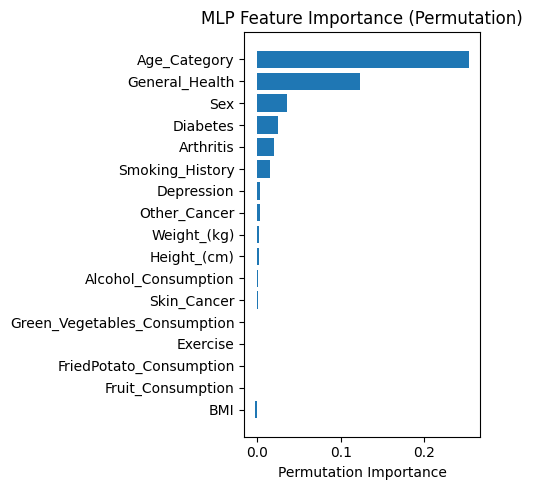

<Figure size 300x300 with 0 Axes>

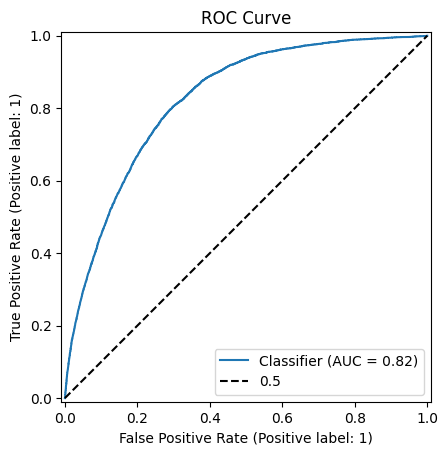

<Figure size 300x300 with 0 Axes>

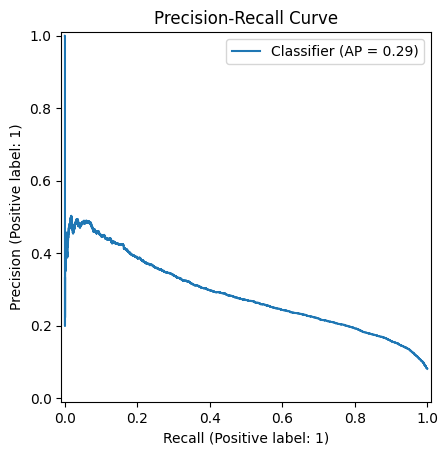

In [7]:
# model evaluation (larger search space)
mlp_params = {
    'hidden_layer_sizes': (271, 247, 429, 372),
    'activation': 'tanh',
    'alpha': 4.561076398918725e-05,
    'learning_rate_init': 0.002382227114640205,
    'batch_size': 64,
    'max_iter': 130,
    'n_iter_no_change': 7,
    'learning_rate': 'adaptive',
    'beta_1': 0.981898845459001,
    'beta_2': 0.9299036895866516,
    
    # normal params:
    'solver': 'adam',
    'random_state': 2024,
    'early_stopping': True,
    'validation_fraction': 0.1,
    'verbose': False,
    'learning_rate': 'constant'}

# train the final model
mlp_model = MLPClassifier(**mlp_params)
mlp_model.fit(X_train_balanced, y_train_balanced)

# make predictions with test set
y_pred = mlp_model.predict(X_test)
y_pred_proba = mlp_model.predict_proba(X_test)[:, 1]

# eval metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# calculate permutation importance
perm_importance = permutation_importance(
    mlp_model, X_test, y_test, 
    n_repeats=10, 
    random_state=1,
    scoring='recall')

feature_names = X_train_balanced.columns if hasattr(X_train_balanced, 'columns') else [f'Feature_{i}' for i in range(X_train_balanced.shape[1])]
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('MLP Feature Importance (Permutation)')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>

### testing my risk score

In [52]:
health = 4.0
exercise = 1
skin_cancer = 0
other_cancer = 0
depression = 0
diabetes = 0
arthritis = 0
sex = 1
age = 21
height = 166.0
weight = 59.0
bmi = 21.0
smoking = 0
alcohol = 15.0
fruit = 20.0
vegetable = 20.0
potato = 5.0


def age_category(age):
    age_ranges = [(0, 25, 0.0), (25, 30, 1.0), (30, 35, 2.0), (35, 40, 3.0), 
        (40, 45, 4.0), (45, 50, 5.0), (50, 55, 6.0), (55, 60, 7.0), (60, 65, 8.0),
        (65, 70, 9.0), (70, 75, 10.0), (75, 80, 11.0), (80, 150, 12.0)]
    for min_age, max_age, category in age_ranges:
        if min_age <= age < max_age:
            return category
age = age_category(age)


my_features = [health, exercise, skin_cancer, other_cancer, depression, diabetes, 
               arthritis, sex, age, height, weight, bmi, smoking, alcohol, fruit, vegetable, potato]

In [53]:
my_features = np.array(my_features).reshape(1, -1)
risk_score = mlp_model.predict_proba(my_features)[0, 1]

print(f"Probability of developing CVD in the next 10 years: {risk_score:.3f}")

Probability of developing CVD in the next 10 years: 0.024
